#  2. Extracting muscle synergies

How can we determine muscle synergies using non-negative matrix factorization in Python?
The goal of this notebook is to figure that out as I read on the topic. We have a sample electromyogram to work with and code to load it to memory. 

## 2.1 Imports and loading the data

We begin by setting up everything: we import the needed libraries and load the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
from pathlib import Path

import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas
from scipy.fftpack import fft, fftfreq
import scipy.signal as signal
import seaborn as sns
from sklearn.decomposition import NMF

from muscle_synergies import load_vicon_file

In [3]:
cwd = Path().resolve()
data_dir = cwd / '..' / 'sample_data'
abridged_dataset = data_dir / 'abridged_data.csv' # useful for testing
full_dataset = data_dir / 'dynamic_trial.csv'
dataset = full_dataset.resolve()
dataset

PosixPath('/home/elvis/Organização/Projetos/Biomecânica/emg-code/muscle_synergies/sample_data/dynamic_trial.csv')

In [4]:
vicon_data = load_vicon_file(dataset)
emg_dev = vicon_data.emg
emg_df = emg_dev.df
time_seq = emg_dev.time_seq()
emg_df.index = time_seq
del vicon_data
emg_df.shape

(124460, 8)

## 2.2 Plotting the signal

### 2.2.1 Time-domain: plotting the raw EMG signal

We first write a function we will use throughout the notebook to plot the time-domain signal as we transform it:

In [5]:
def plot_emg_signal(emg_df, title, xlabel='time (s)', ylabel='Volts', xticks_off=False):
    """Plot EMG DataFrame with 8 columns."""
    fig, axs = plt.subplots(2, 4, figsize=(18, 10))
    for (ax, col) in zip(axs.flat, emg_df.columns):
        emg_df[col].plot(ax=ax)
        ax.set_title(col)
        if xticks_off:
            ax.set_xticks([], [])
        ax.set(xlabel=xlabel)
    fig.suptitle(title, fontsize=20)
    axs[0, 0].set_ylabel(ylabel)
    axs[1, 0].set_ylabel(ylabel)
    plt.show()

And plot the raw signal:

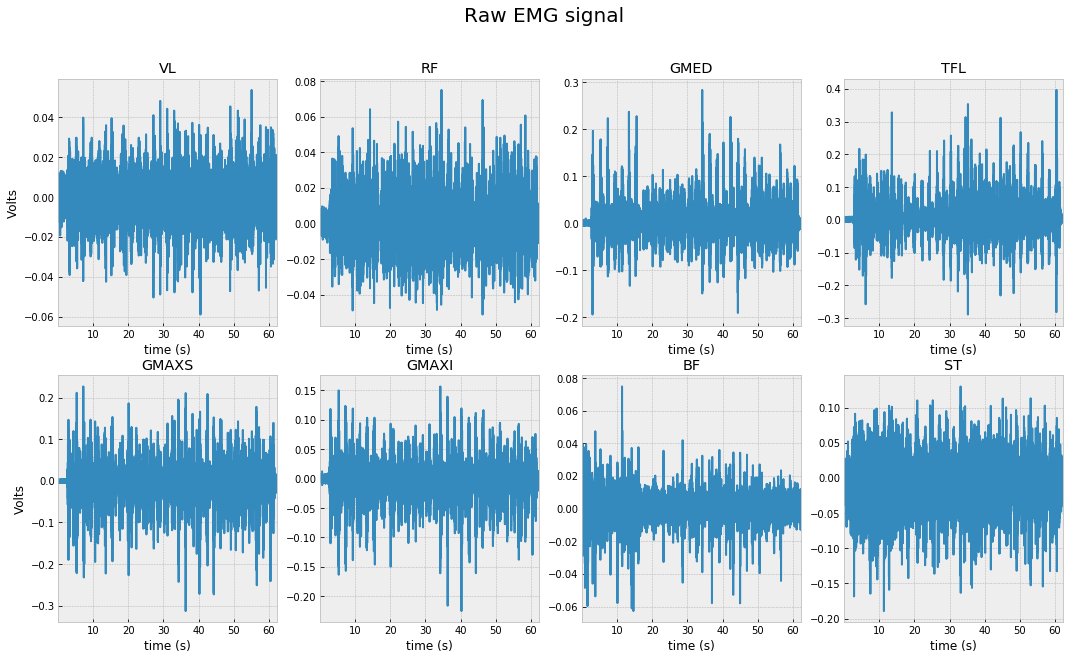

In [6]:
plot_emg_signal(emg_df, 'Raw EMG signal')

### 2.2.2 Frequency-domain: plotting the FFT

We are interested in seeing the frequency-domain version of the EMG signal mostly to look for abnormalities. First, compute the transform and the corresponding frequencies:

In [7]:
num_samples = emg_df.shape[0]
sample_spacing = 1. / emg_dev.sampling_frequency
fft_freqs = fftfreq(num_samples, sample_spacing)
positive_freq_ind = fft_freqs > 0
fft_freqs = fft_freqs[positive_freq_ind]

fft_arr = fft(emg_df, axis=0)
fft_ampls_arr = np.abs(fft_arr[positive_freq_ind])
positive_freq_df = pandas.DataFrame(fft_ampls_arr, 
                               index=fft_freqs,
                               columns=emg_df.columns)

Now plot the spectrum:

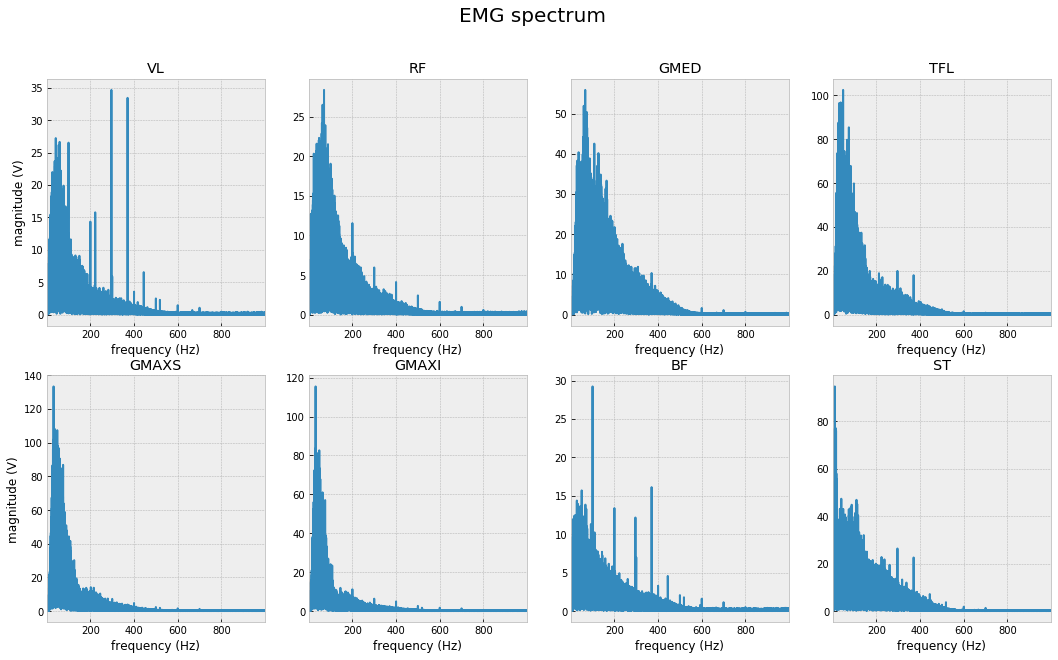

In [8]:
plot_emg_signal(positive_freq_df, 
                title="EMG spectrum",
                xlabel="frequency (Hz)",
                ylabel="magnitude (V)",
                xticks_off=False)

## 2.3 Zero-centering the signal

We begin processing the data by subtracting the mean of the signal from each of its channels:

In [9]:
emg_df -= emg_df.mean()

## 2.4 Bandpass-filtering the signal

Before applying any filter, we implement a generic Butterworth-filter that we can reuse later (modified from [this example](https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html)):

In [10]:
def butterworth_filter(data, critical_freqs, sampling_freq, order,
                       filter_type='lowpass', zero_lag=True):
    """Apply Butterworth filter to the data."""
    filter_coeffs = _filter_coeffs(order, sampling_freq, critical_freqs, filter_type)
    
    if zero_lag:
        filt_func = signal.sosfiltfilt
    else:
        filt_func = signal.sosfilt
        
    return filt_func(filter_coeffs, data, axis=0)


def _filter_coeffs(order: int,
                   sampling_freq: int,
                   critical_freqs,
                   filter_type='lowpass'):
    """Determine Butterworth filter coefficients."""
    return signal.butter(order, critical_freqs, 
                         btype=filter_type, output='sos', fs=sampling_freq)

We bandpass-filter the signal:

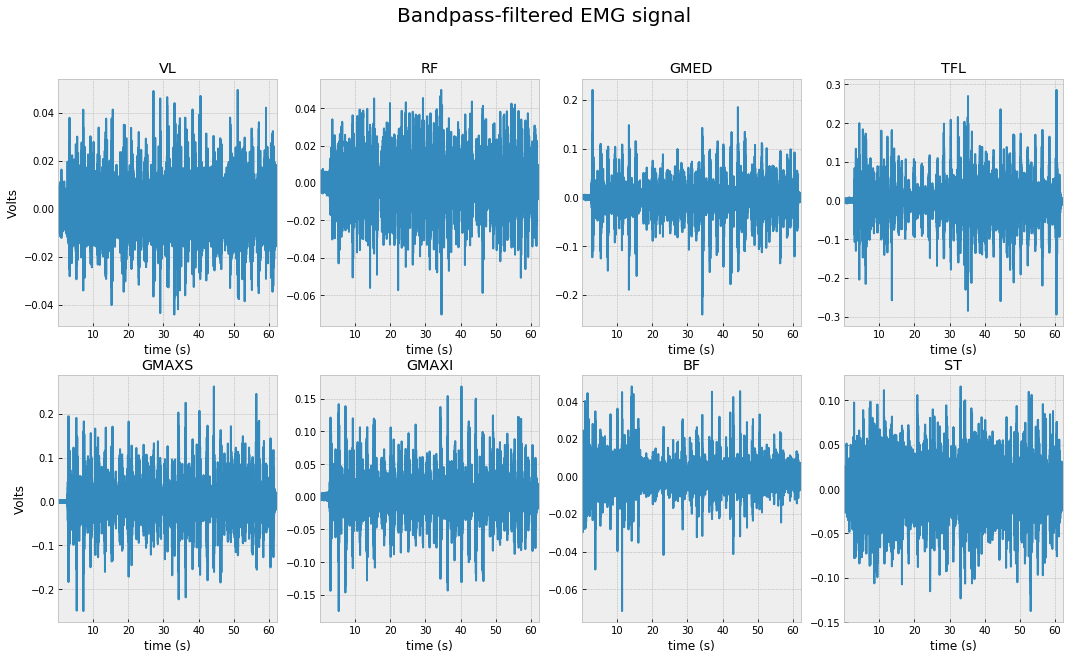

In [11]:
filtered_arr = butterworth_filter(emg_df.to_numpy(), (20, 200), emg_dev.sampling_frequency,
                                  order=6, filter_type='bandpass', zero_lag=False)
bandpass_filtered_df = pandas.DataFrame(filtered_arr, 
                                        columns=emg_df.columns,
                                        index=emg_df.index)
plot_emg_signal(bandpass_filtered_df, "Bandpass-filtered EMG signal")

## 2.5 Finding the envelope of the signal

We'll investigate both the linear envelope and RMS.

### 2.5.1 Linear envelope

To find the linear envelope, rectify then low-pass filter the signal.

#### 2.5.1.1 Rectifying the signal

Rectify each of the channels of the electromyogram:

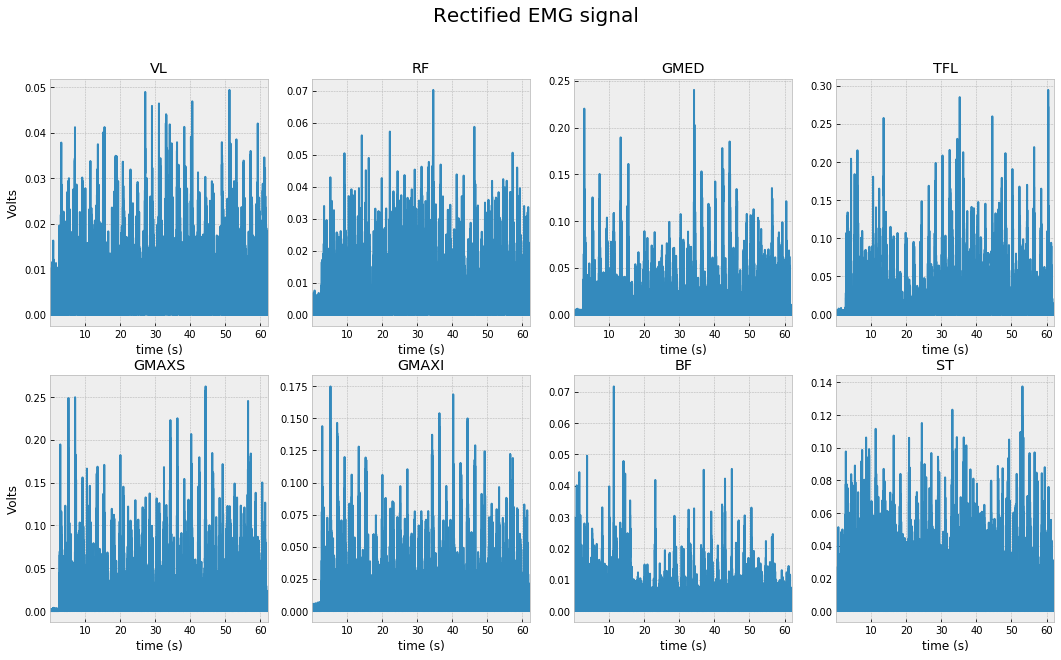

In [12]:
rectified_df = np.abs(bandpass_filtered_df)
plot_emg_signal(rectified_df, 'Rectified EMG signal')

We can be confident that there are no negative values in the signals above since they have been through `np.abs`.

#### 2.5.1.2 Applying the Butterworth filter

Low-pass filter the signal using a zero-lag order Butterworth filter: 

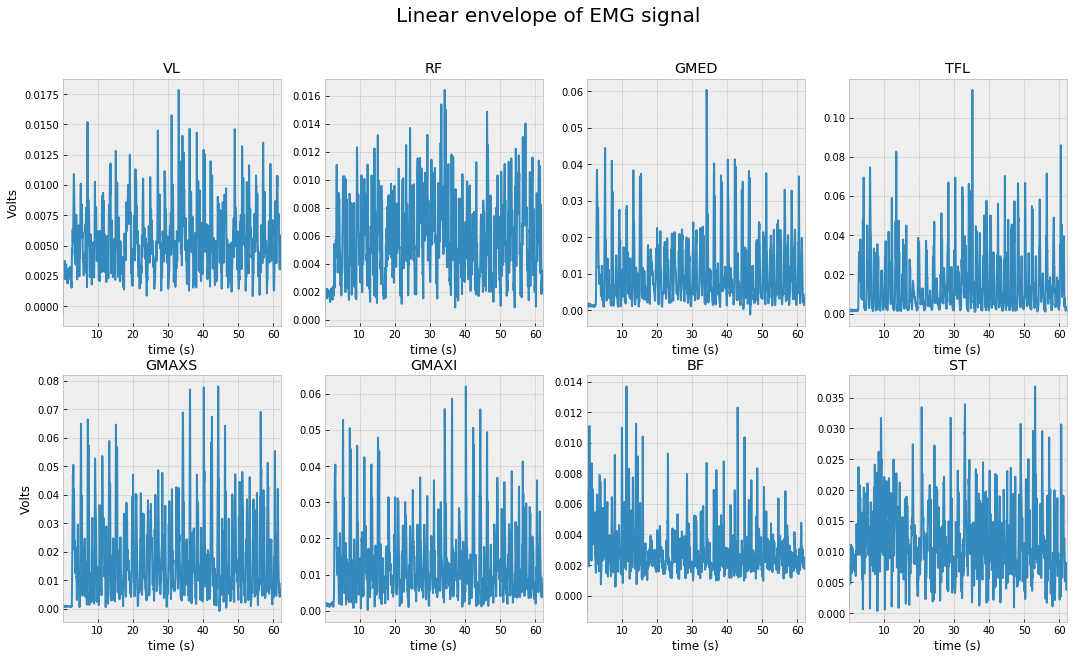

In [13]:
filtered_arr = butterworth_filter(rectified_df.to_numpy(), 6, emg_dev.sampling_frequency,
                                  order=4, filter_type='lowpass', zero_lag=True)
linear_envelope_df = pandas.DataFrame(filtered_arr, columns=emg_df.columns, 
                                      index=emg_df.index)
plot_emg_signal(linear_envelope_df, 'Linear envelope of EMG signal')

The graphs reveal that some of the channels of the filtered signal become negative at some times. We can check that by looking at the data directly:

In [14]:
(linear_envelope_df < 0).sum()

VL       17
RF        0
GMED     92
TFL      17
GMAXS    81
GMAXI     5
BF       13
ST        0
dtype: int64

We can see that several of the columns include negative measurements following the application of the low-pass Butterworth filter.

### 2.5.2 RMS

Define a function that applies the RMS transformation (inspired by [this](https://stackoverflow.com/questions/8245687/numpy-root-mean-squared-rms-smoothing-of-a-signal)):

In [15]:
def _single_channel_rms(signal: np.ndarray, window_size: int):
    square = signal ** 2
    window_mean_factor = 1 / float(window_size)
    window = window_mean_factor * np.ones(window_size) 
    return np.sqrt(np.convolve(square, window, 'same'))

def rms_envelope(emg_signal, window_size: int):
    fixed_window_rms = functools.partial(_single_channel_rms, window_size=window_size)
    return np.apply_along_axis(fixed_window_rms, 0, emg_signal)

Find the RMS envelope using that transformation:

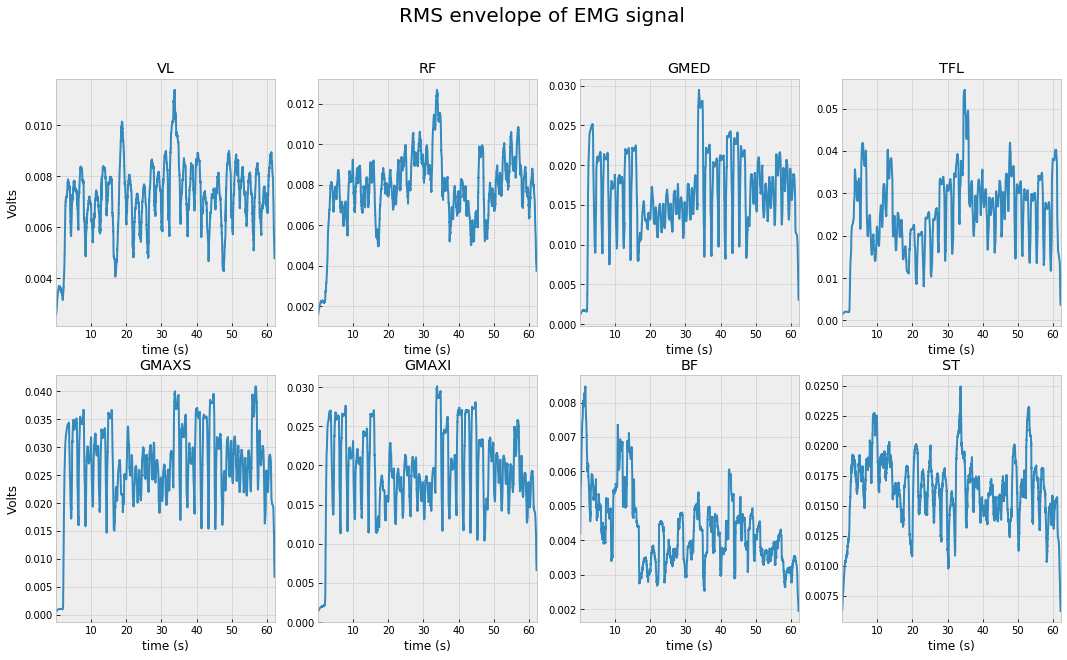

In [16]:
window_size = 3000
filtered_arr = rms_envelope(bandpass_filtered_df, window_size)
rms_envelope_df = pandas.DataFrame(filtered_arr, columns=emg_df.columns, index=emg_df.index)
plot_emg_signal(rms_envelope_df, 'RMS envelope of EMG signal')

We can be sure that the RMS-processed signal will only contain nonnegative values since it squared every value in the raw signal. 
For that reason we opt to use it for further processing:

In [17]:
processed_df = rms_envelope_df

## 2.6 Normalizing the signal

We now normalize the envelope signal in two ways: 

### 2.6.1 Amplitude normalization

The signal is amplitude normalized by dividing all measurements for each of its channels by the maximum value for that channel.

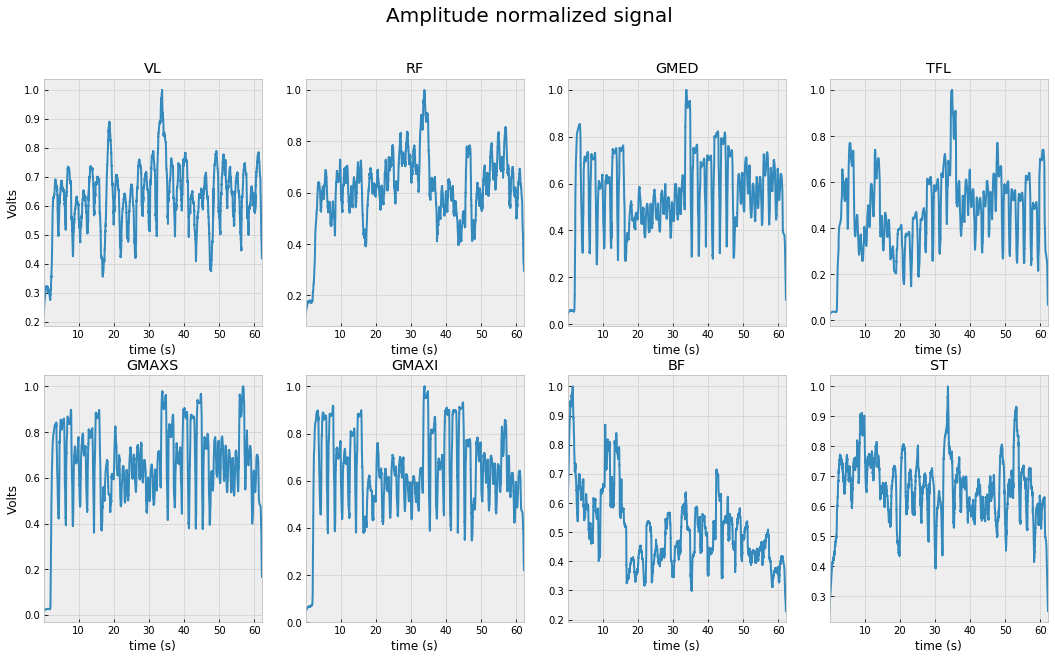

In [18]:
processed_df /= processed_df.max()
plot_emg_signal(processed_df, 'Amplitude normalized signal')

### 2.6.2 Time normalization

The signal is sampled down. Its original shape...

In [19]:
processed_df.shape

(124460, 8)

...is reduced by resampling points:

In [20]:
processed_arr = signal.resample(processed_df, 100, axis=0)
processed_df = pandas.DataFrame(processed_arr, columns=emg_df.columns)
processed_df.shape

(100, 8)

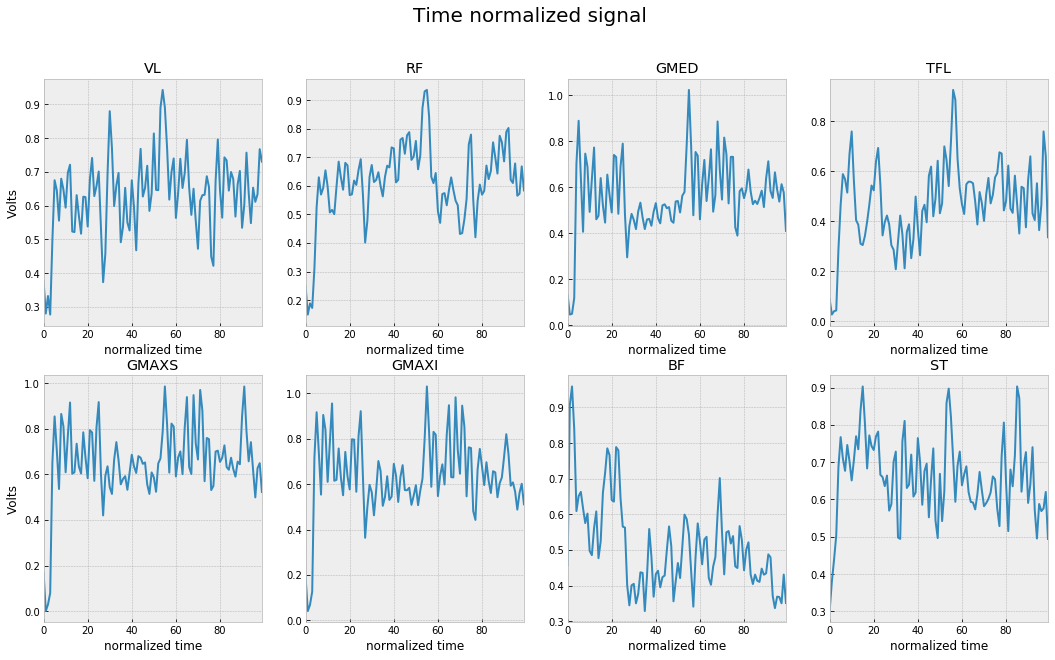

In [21]:
plot_emg_signal(processed_df, 'Time normalized signal', xlabel='normalized time')

We make sure that we have no negative measurements:

In [22]:
(processed_df < 0).sum()

VL       0
RF       0
GMED     0
TFL      0
GMAXS    0
GMAXI    0
BF       0
ST       0
dtype: int64

## 2.7 Finding the synergies

We finally try to determine the muscle synergies.

### 2.7.1 Factoring the matrix

Begin by factoring the matrix:

In [23]:
model = NMF(max_iter=100000, tol=1e-6)
transformed_emg_signal = model.fit_transform(processed_df)
print('number of iterations: ', model.n_iter_)

number of iterations:  23539


### 2.7.2 Visualizing the components

The synergies are given by an 8 x 8 matrix:

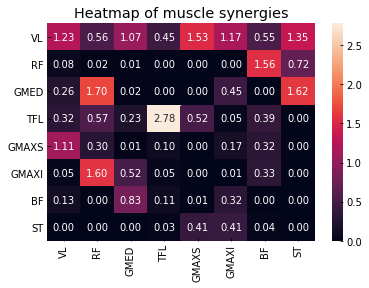

In [24]:
synergies = pandas.DataFrame(model.components_, index=emg_df.columns, columns=emg_df.columns)
sns.heatmap(synergies, annot=True, fmt='.2f')
plt.title('Heatmap of muscle synergies')
plt.show()

### 2.7.3 Investigating the fit: how much variance does it explain?

The 8 synergy components we arrived at by factoring the matrix are supposed to explain well the signal. We check that by comparing the original signal with its counterpart constructed as a linear combination of those components. 
We get the relative error by divinding the absolute difference between the reconstructed signal and the original one by the original signal.

The mean of this relative error (per channel):

In [25]:
unexplained_variation_df = (processed_df - transformed_emg_signal @ model.components_)
unexplained_variation_df /= processed_df
unexplained_variation_df = unexplained_variation_df.abs()
unexplained_variation_df.mean()

VL       2.754059e-07
RF       9.424151e-08
GMED     1.253120e-06
TFL      1.690226e-05
GMAXS    3.075683e-03
GMAXI    1.513729e-06
BF       2.860550e-08
ST       8.618206e-08
dtype: float64

The maximum relative error per channel between the reconstructed signal and the original one:

In [26]:
unexplained_variation_df.max()

VL       1.273231e-05
RF       2.714698e-06
GMED     6.141090e-05
TFL      9.162538e-04
GMAXS    3.074192e-01
GMAXI    9.123900e-05
BF       6.627249e-07
ST       2.438699e-06
dtype: float64